In [1]:
import numpy as np
import pandas as pd
import re
import os
from io import StringIO

from sklearn.externals import joblib
from scipy.sparse import csr_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

%matplotlib inline

# Релизация модели FM

In [2]:
def RMSE_score(y_pred, y_real):
    return np.sqrt(np.sum(np.power(y_pred - y_real, 2)) / y_pred.shape[0])

def R2_score(y_pred, y_real):
    return 1 - np.sum(np.power(y_pred - y_real, 2)) / np.sum(np.power(y_real - np.mean(y_real), 2))

def R2_adj_score(y_pred, y_real, features):
    R2 = R2_score(y_pred, y_real)
    return 1 - (1 - R2) * (y_real.shape[0] - 1) / (y_real.shape[0] - features - 1)

In [40]:
class SGD2WAYFactorizationMachine(object):
    def __init__(self, k=5, epochs=5, epsilon=1e-4, step=0.001, step_V=None, verbose=0, nobs_verbose=10):
        self.epochs = epochs
        self.epsilon = epsilon
        self.step = step
        self.verbose = verbose
        self.nobs_verbose = nobs_verbose
        if step_V:
            self.stepV = step_V
        else:
            self.stepV = self.step / 10
        self.k = k
        
        self.w0 = None
        self.w1 = None
        self.V = None
    
    def fit(self, X, y):
        self.w0 = 0
        self.w1 = np.random.normal(size=X.shape[1], scale=1)
        self.V = np.random.normal(size = (X.shape[1], self.k), scale=1)
        
        
        n = X.shape[0]
        
        for epoch in range(1, self.epochs + 1):
            prev_w0 = np.copy(self.w0)
            prev_w1 = np.copy(self.w1)
            prev_V = np.copy(self.V)

            
            # precalc Y gradient for chaining rule (dw = dL/dy * dy/dw)
            #dY = -(y - y_hat)
            for nobs, obs in enumerate(X):
                if nobs % self.nobs_verbose == 0 and self.verbose == 1:
                    print('{}-th observation'.format(nobs))
                y_hat = self.predict(obs)
                dy = -2 * (y[nobs] - y_hat)
                self.w0 -= dy * (self.step / epoch)
                self.w1 -= dy * obs * (self.step / epoch)
                
                dV = np.zeros_like(self.V)
                for i in range(self.V.shape[0]):
                    for f in range(self.V.shape[1]):
                        dV[i, f] = obs[i] * (self.V[:, f] @ obs) - self.V[i, f] * obs[i] * obs[i]
                        self.V[i, f] -= dy * dV[i, f] * self.stepV

            norm = (np.abs(self.w0 - prev_w0) + np.linalg.norm(self.w1 - prev_w1) + np.linalg.norm(self.V - prev_V)) / 3
            if norm < self.epsilon:
                print('parameters converged')
                return
    
    def calculate_nonlinear_part(self, X):
        cumsum = 0
        for i in range(self.V.shape[1] - 1):
            cumsum += np.power(self.V[:, i] @ X.T, 2) - np.power(self.V[:, i], 2) @ np.power(X, 2).T
        
        #for i in range(self.V.shape[0] - 1):
        #    for j in range(i+1, self.V.shape[0]):
        #        cumsum += (self.V[i, :] @ self.V[j, :].T) * X[:, i] * X[:, j]
        return cumsum
    
    def calculate_nonlinear_part_singleobs(self, x):
        # maybe it can speedup a lil bit...
        cumsum = 0
        
        for i in range(self.V.shape[1] - 1):
            cumsum += np.power(self.V[:, i] @ x, 2) - np.power(self.V[:, i], 2) @ np.power(x, 2)
        #for i in range(self.V.shape[0] - 1):
        #    for j in range(i+1, self.V.shape[0]):
        #        cumsum += (self.V[i, :] @ self.V[j, :].T) * x[i] * x[j]
        return cumsum / 2
        
    def predict(self, X):
        if len(X.shape) == 2:
            return self.w0 + X @ self.w1 + self.calculate_nonlinear_part(X)
        else:
            return self.w0 + X @ self.w1 + self.calculate_nonlinear_part_singleobs(X) 

# Проверка корректности работы алгоритма на примере искусственного датасета

# и сравнение с SGD регрессором sklearn

In [41]:
from sklearn.datasets import make_regression
from sklearn.linear_model import SGDRegressor

In [51]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=3)

In [52]:
fm = SGD2WAYFactorizationMachine(epochs=10, k=4, step=0.001, step_V=0.00001)
reg = SGDRegressor(fit_intercept=True, penalty='none', shuffle=False, learning_rate='constant', eta0=0.0001, max_iter=10)

In [53]:
reg.fit(X, y)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.0001,
       fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
       loss='squared_loss', max_iter=10, n_iter=None, penalty='none',
       power_t=0.25, random_state=None, shuffle=False, tol=None, verbose=0,
       warm_start=False)

In [54]:
fm.fit(X, y)

In [55]:
reg.coef_, reg.intercept_

(array([ 0.83838014, 32.36424932, 19.39660857, -0.09382199,  0.2908992 ,
         2.66198705,  2.0933585 ,  0.76610217,  0.36110381, 52.09245891]),
 array([-1.0309923]))

In [56]:
fm.w1, fm.w0, fm.V

(array([-5.94203705e-02,  5.36782450e+01,  2.64905712e+01, -8.52967995e-02,
        -2.75662201e-02,  1.22516241e-01,  9.40340472e-02, -3.56189054e-02,
        -9.32514622e-02,  8.55106218e+01]),
 -0.11967503795305239,
 array([[-0.37187951,  0.45912204,  0.59570816, -3.09525857],
        [ 0.25790071,  0.46519432, -0.32317119,  0.32112894],
        [-0.02499659,  0.1339452 ,  0.13787176,  0.10369574],
        [-0.55413571,  0.41397531,  0.94694148,  1.55283278],
        [ 0.36330264, -0.24761672,  0.13117022,  2.0054282 ],
        [ 0.28882273, -0.02085974, -0.06951341, -1.31546993],
        [ 0.64042274, -1.5527573 ,  0.3284842 , -1.43001478],
        [-0.65723609, -0.40602883, -0.37173831, -0.49254596],
        [ 0.86351267,  0.5110508 , -0.26431092, -1.07864236],
        [ 0.83274367,  0.25198965,  0.898097  ,  1.25047922]]))

In [60]:
reg.predict(X[:5])

array([104.22174246, -86.56265448, -38.04491239,  22.90614193,
       -82.0914228 ])

In [61]:
fm.predict(X[:5])

array([ 149.51558509, -125.87380668,  -48.21653458,   46.20227453,
       -133.42222577])

In [62]:
y[:5]

array([ 156.61904893, -126.25850739,  -47.3664819 ,   43.42584332,
       -135.89882643])

# Работа с данными

## Загрузка датасета

In [15]:
txtfile = None

In [141]:
if txtfile:
    del txtfile

with open('Task2/netflix-prize-data/combined_data_1.txt', 'r') as f:
    txtfile = f.read()

In [142]:
# movies ids
film_ids = list(map(lambda x: int(x[:-1]), re.findall(r'\d+\:', txtfile)))
# separate frames
frames_raw = re.split(r'\d+\:', txtfile)
frames_raw = frames_raw[1:]

In [143]:
frames_totale = []

for frame, movie_id in zip(frames_raw, film_ids):
    sub_df = pd.read_csv(StringIO(frame), names=['CustomerID','Rating','Date'])
    sub_df['MovieID'] = movie_id
    
    frames_totale.append(sub_df)
    
dataset = pd.concat(frames_totale)

## Фильтруем редкие записи

In [144]:
users_to_ratings = dataset['CustomerID'].value_counts()

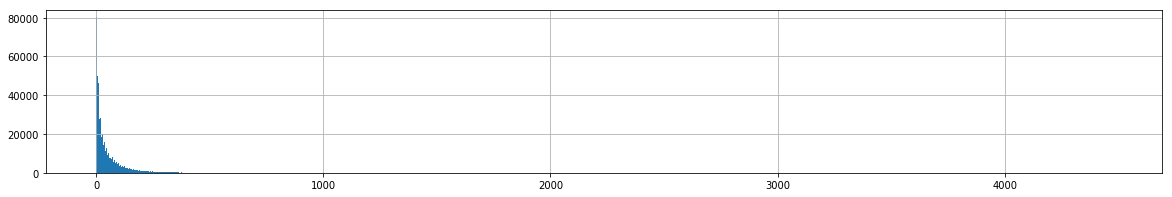

In [145]:
users_to_ratings.hist(bins=1000, figsize=(20, 3))

In [211]:
users_to_ratings.shape, users_to_ratings[users_to_ratings>1000].shape

((470758,), (85,))

In [227]:
active_users = users_to_ratings[users_to_ratings>1000].index

In [213]:
movies_to_ratings = dataset['MovieID'].value_counts()

In [216]:
movies_to_ratings.shape, movies_to_ratings[movies_to_ratings>15000].shape

((4499,), (378,))

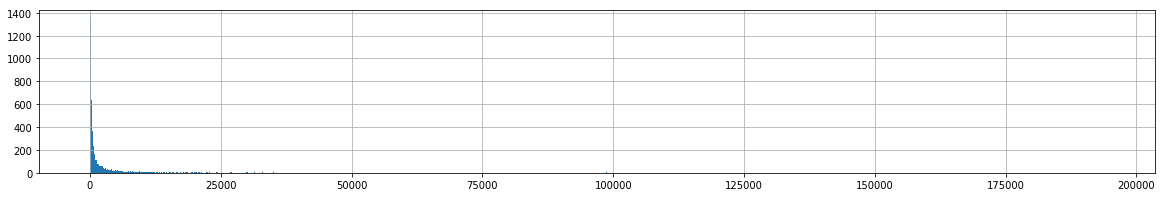

In [217]:
movies_to_ratings.hist(bins=1000, figsize=(20, 3))

In [228]:
popular_movies = movies_to_ratings[movies_to_ratings>15000].index

In [229]:
df = dataset[dataset.MovieID.isin(popular_movies) & dataset.CustomerID.isin(active_users)]

In [230]:
df.shape

(24934, 4)

## Таблица с фичами для фильмов

In [231]:
if txtfile:
    del txtfile
    
with open('Task2/netflix-prize-data/movie_titles.csv', 'r') as f:
    txtfile = f.read()

subs = re.compile(r'\d+,\d+,')
new_lines = []
for i in txtfile.split('\n'):
    sub_part = subs.sub('', i)
    if 'NULL' not in sub_part:
        if ',' not in sub_part:
            new_lines.append(i)
        else:
            left_part = i.replace(sub_part, '')
            right_part = sub_part
            new_lines.append(left_part + '"' + right_part + '"')
        
movie_info = '\n'.join(new_lines)
movie_table = pd.read_csv(StringIO(movie_info), names = ['MovieID', 'Year', 'Name'])

movie_table.MovieID = movie_table.MovieID.astype(int)
movie_table.Year = movie_table.Year.astype(int)

In [232]:
movie_table_filtered = movie_table[movie_table.MovieID.isin(popular_movies.values)]

In [233]:
movie_table_filtered = movie_table_filtered.set_index('MovieID')

In [234]:
features = df.CustomerID.unique().shape[0] + movie_table_filtered.Year.unique().shape[0] + movie_table_filtered.shape[0]

In [235]:
print('Число фичей', features)

Число фичей 510


In [262]:
k = 3
print('Число параметров в модели', 1 + features + k*features)

Число параметров в модели 2041


### Формируем датасет для обучения

In [246]:
max_movies = popular_movies.shape[0]
max_users = active_users.shape[0]
max_years = movie_table_filtered.Year.unique().shape[0]

In [247]:
#encode year
years_mapping = dict(zip(movie_table_filtered.Year.unique(), range(movie_table_filtered.Year.unique().shape[0])))
users_mapping = dict(zip(active_users, range(active_users.shape[0])))
movies_mapping = dict(zip(popular_movies, range(popular_movies.shape[0])))

In [313]:
X = []
y = []
count = 1
for _, i in df.iterrows():
    if count % 20000 == 0:
        print('%.2f' % (count / df.shape[0]))
        
    id_movie = i['MovieID']
    id_customer = i['CustomerID']
    rating = i['Rating']
    year = movie_table_filtered.loc[id_movie].Year
    row = np.zeros(features)
    
    row[movies_mapping[id_movie]] = 1
    row[max_movies + users_mapping[id_customer]] = 1
    row[max_movies + max_users + years_mapping[year]] = 1
    
    X.append(row)
    y.append(rating)
    count += 1

0.80


In [314]:
X = np.array(X)

### сожмем матрицу

In [315]:
X_sparse = csr_matrix(X)

In [316]:
y = np.array(y).reshape(-1, 1)

In [317]:
os.makedirs('./Task2/processed/', exist_ok=True)
joblib.dump(X_sparse, './Task2/processed/X.bin')
joblib.dump(y, './Task2/processed/y.bin')

['./Task2/processed/y.bin']

### попытка обучить модель

In [64]:
y = joblib.load('./Task2/processed/y.bin')
X = joblib.load('./Task2/processed/X.bin')

In [65]:
y = np.array(y).squeeze()

In [66]:
X = np.array(X.todense())

In [67]:
X, y = shuffle(X, y)

In [68]:
rmse_train = []
rmse_test = []
r2_train = []
r2_test = []
r2_adj_train = []
r2_adj_test = []
features = []
features_names = []

kfold = KFold(n_splits=8)

for ix_train, ix_test in kfold.split(X):
    print('new fold')
    mdl = SGD2WAYFactorizationMachine(epochs=1, k=2, step=0.001, step_V=0.0001, verbose=1, nobs_verbose=5000)
    
    X_train = X[ix_train]
    y_train = y[ix_train]
    
    X_test = X[ix_test]
    y_test = y[ix_test]
    
    mdl.fit(X_train, y_train)
    
    rmse_test.append(RMSE_score(mdl.predict(X_test), y_test))
    r2_test.append(R2_score(mdl.predict(X_test), y_test))
    r2_adj_test.append(R2_adj_score(mdl.predict(X_test), y_test, X.shape[1]))
    
    rmse_train.append(RMSE_score(mdl.predict(X_train), y_train))
    r2_train.append(R2_score(mdl.predict(X_train), y_train))
    r2_adj_train.append(R2_adj_score(mdl.predict(X_train), y_train, X.shape[1]))
    
    
    #temp = sorted(zip(X.columns, mdl.w), key=lambda x: -np.abs(x[1]))
    #features.append(mdl.w)
    #features_names.append([i[0] for i in temp])

new fold
0-th observation
5000-th observation
10000-th observation
15000-th observation
20000-th observation
new fold
0-th observation
5000-th observation
10000-th observation
15000-th observation
20000-th observation
new fold
0-th observation
5000-th observation
10000-th observation
15000-th observation
20000-th observation
new fold
0-th observation
5000-th observation
10000-th observation
15000-th observation
20000-th observation
new fold
0-th observation
5000-th observation
10000-th observation
15000-th observation
20000-th observation
new fold
0-th observation
5000-th observation
10000-th observation
15000-th observation
20000-th observation
new fold
0-th observation
5000-th observation
10000-th observation
15000-th observation
20000-th observation
new fold
0-th observation
5000-th observation
10000-th observation
15000-th observation
20000-th observation


In [69]:
df = pd.DataFrame(np.vstack([r2_test, r2_train, r2_adj_test, r2_adj_train, rmse_test, rmse_train]), index=[
    'r2_test',
    'r2_train',
    'r2_adj_test',
    'r2_adj_train',
    'rmse_test',
    'rmse_train',
])

df = pd.concat([df, df.mean(axis=1).rename('mean'), df.std(axis=1).rename('std')], axis=1)

df

,0,1,2,3,4,5,6,7,mean,std
r2_test,-3.546568,-4.332787,-4.201231,-4.883857,-5.348082,-3.974355,-3.508859,-4.438080,-4.279227,0.628538
r2_train,-3.547276,-3.902593,-3.607944,-4.774509,-4.850212,-4.259810,-3.595443,-4.400508,-4.117287,0.530822
r2_adj_test,-4.436342,-5.376426,-5.219124,-6.035340,-6.590415,-4.947848,-4.391591,-5.502733,-5.312477,0.751499
r2_adj_train,-3.656124,-4.019946,-3.718244,-4.912733,-4.990248,-4.385714,-3.705439,-4.529774,-4.239778,0.543529
rmse_test,2.782706,3.009414,2.944782,3.149160,3.255060,2.904664,2.795153,3.024253,2.983149,0.163457
rmse_train,2.772678,2.879574,2.795316,3.126856,3.149465,2.982850,2.783487,3.024361,2.939323,0.153445
